##### Copyright 2023 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In this codelab, you will learn to use [KerasNLP](https://keras.io/keras_nlp/) to load a pre-trained Large Language Model (LLM) - [GPT-2 model](https://openai.com/research/better-language-models) (originally invented by OpenAI), finetune it to a specific text style, optimize it and convert it to [TensorFlow Lite](https://www.tensorflow.org/lite), so that it can be deployed in an Android app to automatically generate text in a certain writing style, based on user input (also known as 'prompt'). Note that GPT-2 is used here only to demonstrate the end-to-end process; the techniques and tooling introduced in this codelab are potentially transferrable to other generative language models such as [T5](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) or [OPT](https://ai.facebook.com/blog/democratizing-access-to-large-scale-language-models-with-opt-175b/).

# Before you begin

Colab offers different kinds of runtimes. Make sure to go to **Runtime -> Change runtime type** and choose the GPU Hardware Accelerator runtime (which should have >12G System RAM and ~15G GPU RAM) since you will finetune the GPT-2 model.

# Imports

Let's first get our imports out of the way.

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git@google-io-2023 tensorflow-text==2.11.0

In [ ]:
import numpy as np
import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow import keras
from tensorflow.lite.python import interpreter
import time

# Introduction to Large Language Models (LLMs)

Large language models (LLMs) are a type of machine learning models that are trained on a large corpus of text data to generate outputs for various natural language processing (NLP) tasks, such as text generation, question answering, and machine translation.

LLMs are typically based on deep learning neural networks, such as the [Transformer architecture](https://arxiv.org/abs/1706.03762) invented by Google researchers in 2017, and are trained on massive amounts of text data, often involving billions of words. These models, such as Google [LaMDA](https://blog.google/technology/ai/lamda/) and [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html), are trained with a large dataset from various data sources which allows them to generate output for many tasks.

LLMs are large because of their sheer size and the vast volumes of data on which they are trained, but at the core they are just language models that can predict the next word in a sentence. Language models do this by analyzing the words that have already been used in the sentence and then using that information to calculate the probability of each possible word. This way LLMs can generate coherent text based on user prompts. For a more pedagogical discussion on language models, you can refer to the [Stanford CS324 LLM course](https://stanford-cs324.github.io/winter2022/lectures/introduction/).

One of the challenges with LLMs is that they are computationally expensive to  run. For example, generating text with a LLM can take several seconds or even minutes on GPUs. This is particular challenging for mobile devices where there are very limited computing power and storage space. But LLMs of smaller scale (e.g., [GPT-2](https://openai.com/research/better-language-models) invented by OpenAI) are more manageable; you can run them fully on device and stil get very impressive results.

# Introduction to KerasNLP

Large Language Models are complex to build and expensive to train from scratch. Luckily there are pretrained LLMs available for use right away. One toolkit that offers state-of-the-art pretrained models for free is [KerasNLP](https://keras.io/keras_nlp/).

KerasNLP is a natural language processing library that supports users through their entire development cycle. The workflows are built from modular components that have state-of-the-art preset weights and architectures when used out-of-the-box and are easily customizable when more control is needed. KerasNLP emphasizes in-graph computation for all workflows so that developers can expect easy productionization using the TensorFlow ecosystem, for example, deployment to mobile devices with TensorFlow Lite.

KerasNLP is a great choice for anyone who wants to build NLP models with Keras. It provides a high-level API for building NLP models, and it includes a variety of pre-trained models and modules. It is easy to use, and it provides a wide range of features. If you are new to NLP, KerasNLP is a great place to start with.

There is also an I/O technical talk 'Applied ML with KerasCV and KerasNLP' by my colleague Jonathan Bischof. Make sure to check that out as well.

## Load a pre-trained GPT-2 model and generate some text

KerasNLP provides a number of pre-trained models, such as [Google Bert](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) and [GPT-2](https://openai.com/research/better-language-models). You can see the list of models available in the [KerasNLP repository](https://github.com/keras-team/keras-nlp/tree/master/keras_nlp/models).

It's very easy to load the GPT-2 model as you can see below:

In [ ]:
gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en")
gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=256,
    add_end_token=True,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en", preprocessor=gpt2_preprocessor)

Once the model is loaded, you can use it to generate some text right away. Run the cells below to give it a try. It's as simple as calling a single function *generate()*:

In [ ]:
start = time.time()

output = gpt2_lm.generate("My trip to Yosemite was", max_length=200)
print("\nGPT-2 output:")
print(output.numpy().decode("utf-8"))

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

Try another one:

In [ ]:
start = time.time()

output = gpt2_lm.generate("That Italian restaurant is", max_length=200)
print("\nGPT-2 output:")
print(output.numpy().decode("utf-8"))

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

Notice how much faster the second call is. This is because the computational graph is compiled in the 1st run and re-used in the 2nd behind the scene.

The quality of the generated text looks OK, but you can improved it via finetuning.

# More on the GPT-2 model from KerasNLP

While it may be sufficient to move on to the next step of finetuning the loaded model now, for the more curious you can better understand how LLMs are built by following this section.

You can check out the full GPT-2 model implementation in KerasNLP on [GitHub](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/). But conceptually the GPT-2 causal language model can be hierarchically broken down into several modules in KerasNLP, all of which have a *from_preset()* function that loads a pretrained model:

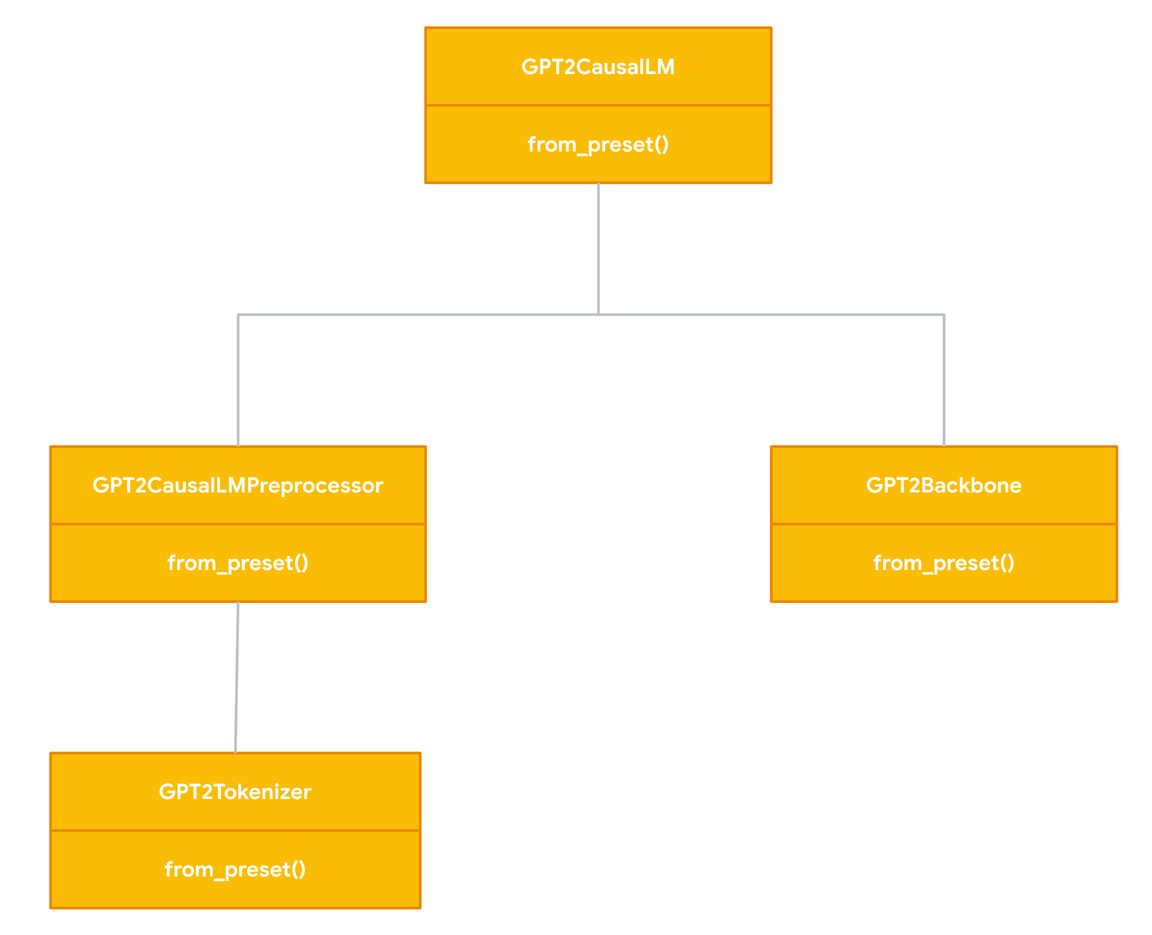

## GPT2Tokenizer

The tokenizer converts your text input into token IDs. There are different kinds of tokenizers; GPT-2 model uses the Byte-Pair Encoding (BPE) tokenizer. You can refer to this [Stanford lecture material](https://stanford-cs324.github.io/winter2022/lectures/modeling/#byte-pair-encoding) for further discussion on BPE tokenization.

In [ ]:
gpt2_tokenizer.tokenize(["Today is a beautiful day"]).flat_values

## GPT2CausalLMPreprocessor

The preprocessor does additional processing, e.g., padding the tensor of token IDs to a specified length, after tokenziation is finished.

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(["Today is a beautiful day"])
preprocessed_ds = ds.map(gpt2_preprocessor)
output = next(iter(preprocessed_ds))
print('token ids:')
print(output[0]['token_ids'])
print('padding masks:')
print(output[0]['padding_mask'])

You can see that a lot of *50256*s are appended to the tensor of token IDs. *50256* is the *'end of sentence'* token for the GPT-2 model and is used to pad the tensor to the length as specified when the preprocessor was created.

Note that the length for the token ID tensor is 255, instead of 256 as specified in `sequence_length` when the preprocessor was created. This is because the label for language models is the next word; so intuititvely the input tensor is shifted toward the end by 1 as labels. Thus, the 256th element is truncated.

## GPT2Backbone

The backbone builds up the neural network and is where real actions happen. Due to the time limit, it's impossible to cover the entire [GPT-2 architecture](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) in this workshop (you can check out the full GPT-2 backbone implementation [here](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/gpt2_backbone.py)). But at a high level GPT-2 is a decoder-only model and its core is a stack of [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) blocks.

The Transformer architecture was invented by several Google researchers in the 2017 paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) and is now the foundational building block for many natural language processsing tasks. It's superior to recurrent and convolutional neural networks because it can better handle long-range dependeies and allows for significantly more parallelization.

You can follow a full Transformer implementation [tutorial](https://www.tensorflow.org/text/tutorials/transformer) at tensorflow.org to learn all the details. But at the core, the Transformer architecture relies on the 'Scaled Dot-Product Attention' (as in the left diagram below). Attention is a mechanism that enables a neural network to selectively focus on certain parts of the input data. 'Scaled Dot-Product Attention' is a specific type of attention, which mathematically is defined as:

$$
Attention(Q,K,V) = \operatorname{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where:

* $Q$ is the query matrix

* $K$ is the key matrix

* $V$ is the value matrix

* $d_k$ is the dimension of the key matrix

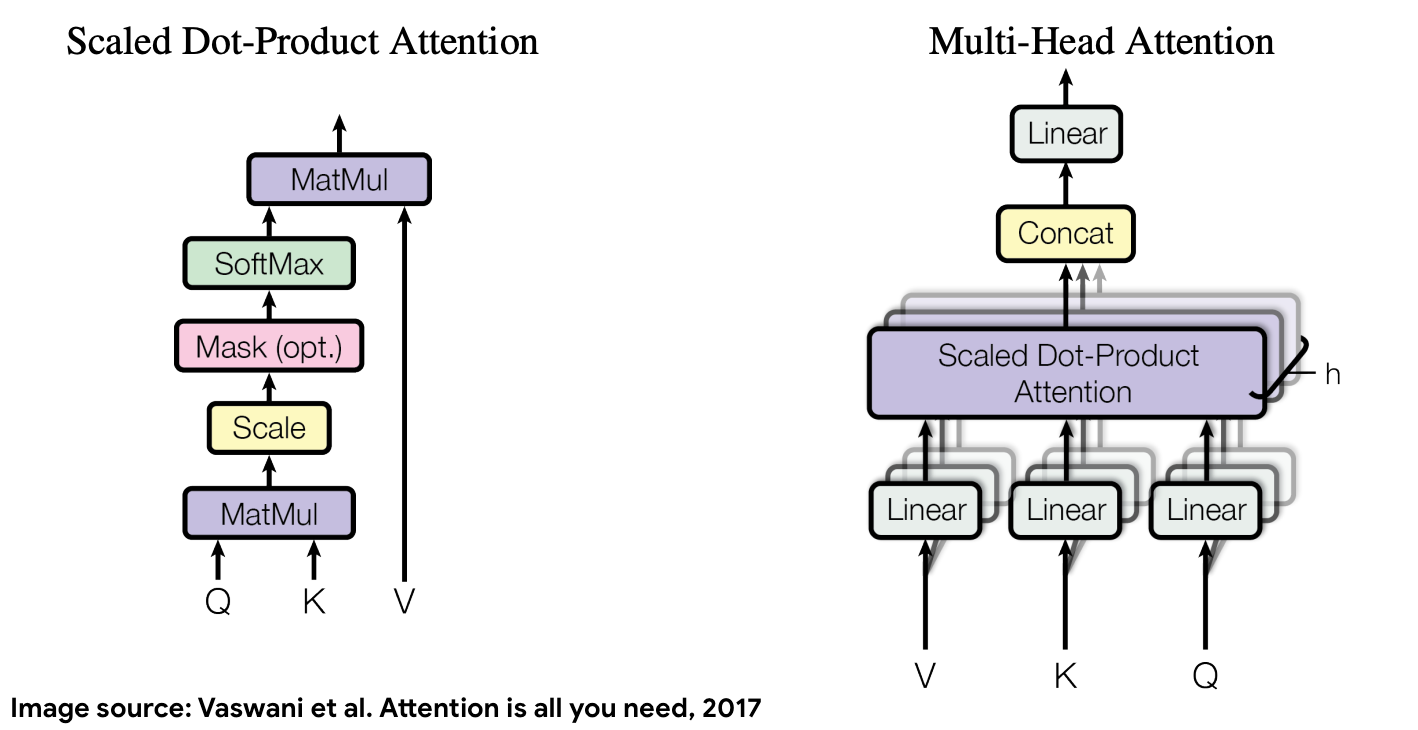

To better understand this conceptually, this attention mechanism is a bit like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s is what sort of information the dictionary has.
- The `value`s is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `value`s, weighted by the "attention scores".

Each location in the query sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.

In practice you will perform the attention function in parallel and concatenate their output, which becomes 'Multi-Head Attention' (MHA) as shown in the right diagram. You can take a look at how the MHA is implemented in [KerasNLP](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/layers/cached_multi_head_attention.py#L24:7).

Another important element in the Transformer architecture is Positional Embedding. Since there is no recurrency or convolution in the Transformer architecture, Positional Embedding is used to inject token position information into the word embedding. In the interest of time, you are recommended to learn more about it in the original [paper](https://arxiv.org/pdf/1706.03762.pdf).

## GPT2CausalLM

Finally, `GPT2CausalLM` has a `predict()` funtion that outputs the next word prediction logits, which can be turned into probabilities through a softmax layer.

In [ ]:
prediction_logits = gpt2_lm.predict(["Today is a beautiful day"])
print(prediction_logits.shape)
print(prediction_logits[0])

Of course, `GPT2CausalLM` has the `generate()` function that generates the prediction text output by repeatedly sampling for the next word from the predicted probability, given the prompt. You have seen how to use it at the very beginning of this colab.

By the way, you may have noticed the word 'causal' in the model name. Transformers are "autoregressive" models: they generate text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

# Finetune on CNN daily dataset (optional)

This step takes more than 30 minutes, so it's optional for the workshop.

Now you have a much better understanding of the GPT-2 model from KerasNLP, you can take one step further to finetune the model so that it generates text in a specific style, for example, CNN's writing style.

Run the following cell to first load the [CNN daily mail](https://www.tensorflow.org/datasets/catalog/cnn_dailymail) dataset using TensorFlow Datasets API:

In [ ]:
start = time.time()

cnn_ds = tfds.load('cnn_dailymail', as_supervised=True)

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

Let's take a look inside a sample of data from the CNN DailyMail TensorFlow Dataset. There are two features:

1. __Article__: text of news article
2. __Highlights__: main points of the article, which could be used as the summary label if you want to do summarization task.

In [ ]:
for article, highlights in cnn_ds['train']:
  print(article.numpy())
  print(highlights.numpy())
  break

In our case, we are performing next word prediction in a language model, so we only need the 'article' feature.

To further prepare our training data, we are going to use a NLP package: [NLTK](https://www.nltk.org/index.html). NLTK helps us download a sentence tokenizer '[punkt](https://www.nltk.org/_modules/nltk/tokenize/punkt.html)', which divides text into a list of sentences.

In [ ]:
from nltk import tokenize
import nltk

nltk.download('punkt')

We define a helper function to merge shorter sentences into longer ones, until they reach a pre-defined `max_length`.

In [ ]:
def merge_sentences(sentences, max_length):
    res = []
    cur_len = 0
    cur_sentences = []
    for s in sentences:
        if cur_len + len(s) > max_length:
            # If adding the next sentence exceeds `max_length`, we add the
            # current sentences into collection
            res.append(" ".join(cur_sentences))
            cur_len = len(s)
            cur_sentences = [s]
        else:
            cur_len += len(s)
            cur_sentences.append(s)
    res.append(" ".join(cur_sentences))
    return res

Next, we can process our training dataset.

In [ ]:
import progressbar

max_length = 512
all_sentences = []
count = 0
total = len(cnn_ds["train"])
num_articles_to_process = 20000
progressbar_update_freq = 2000

widgets = [' [',
         progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]

# Render a progressbar to track progress
bar = progressbar.ProgressBar(
    max_value=num_articles_to_process // progressbar_update_freq + 2,
    widgets=widgets).start()

for article, highlight in cnn_ds['train']:
  # Use NLTK tokenize to split articles into sentences
  sentences = tokenize.sent_tokenize(str(article))
  # Merge individual sentences into longer context
  combined_res = merge_sentences(sentences, max_length)
  # Add merged context into collection
  all_sentences.extend(combined_res)
  count += 1
  if count % progressbar_update_freq == 0:
    bar.update(count / progressbar_update_freq)
  if count >= num_articles_to_process:
    break

The next step is to create a TensorFlow Dataset and run preprocessing on it. Note that here we use tf.data API to map the `gpt2_preprocessor` against the training dataset.

In the interest of time, here only a small subset of the training data are taken as the training set.

In [ ]:
tf_train_ds = tf.data.Dataset.from_tensor_slices(all_sentences)
processed_ds = tf_train_ds.map(gpt2_preprocessor, tf.data.AUTOTUNE).batch(20).cache().prefetch(tf.data.AUTOTUNE)
part_of_ds = processed_ds.take(100)

Now you can finetune the model using the familiar *fit()* function. Note that *include_preprocessing* in the `gpt2_lm` model is turned off, since preprocessing was performed in the previous step.

This step takes quite a bit of GPU memory and a long time if we were to train it all the way to a fully trained state. Here we just train 1 epoch as a demonstration:

In [ ]:
gpt2_lm.include_preprocessing = False

num_epochs = 1

lr = tf.keras.optimizers.schedules.PolynomialDecay(
    5e-5,
    decay_steps=part_of_ds.cardinality() * num_epochs,
    end_learning_rate=0.0,
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
gpt2_lm.compile(
    optimizer=keras.optimizers.experimental.Adam(lr),
    loss=loss,
    weighted_metrics=["accuracy"])

gpt2_lm.fit(part_of_ds, epochs=num_epochs)

After finetuning is finished, you can again generate text using the same *generate()* function. This time, the text will be closer to CNN's writing style.

In [ ]:
start = time.time()

output = gpt2_lm.generate("Breaking news: the river", max_length=200)
print("\nGPT-2 output:")
print(output.numpy().decode("utf-8"))

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

You can save the finetuned weights for future usage.

In [ ]:
gpt2_lm.backbone.save_weights("finetuned_model.h5")

You can of course finetune the model to any writing style as you want, as long as you can provide the training dataset. This is left to you as an exercise.

# Load a finetuned GPT-2 model

Since it takes a long time to finetune the GPT-2 model to completion, you can load a GPT-2 model finetuned on the CNN daily mail dataset, directly from KerasNLP.

In [ ]:
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en_cnn_dailymail")
# Alternative model: finetuned on Reddit dataset
# gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en_reddit")
gpt2_lm.generate(
    ["Breaking news: the river"],
    max_length=200,
)

# Introduction to TensorFlow Lite

Now the model can generate text of the intended style. But this runs on a powerful GPU sitting in the cloud. How can we leverage it on a mobile device?

One solution is to build a backend service using KerasNLP and send requests from mobile devices to the endpoint. But a better way is to run the model purely on device using On-Device Machine Learning (ODML). This is where TensorFlow Lite comes into the picture.

[TensorFlow Lite](https://www.tensorflow.org/lite) is a mobile library for deploying models on mobile, microcontrollers and other edge devices. You can learn more about TensorFlow Lite from its [homepage](https://www.tensorflow.org/lite), but here is a conceptual architecture for TensorFlow Lite:

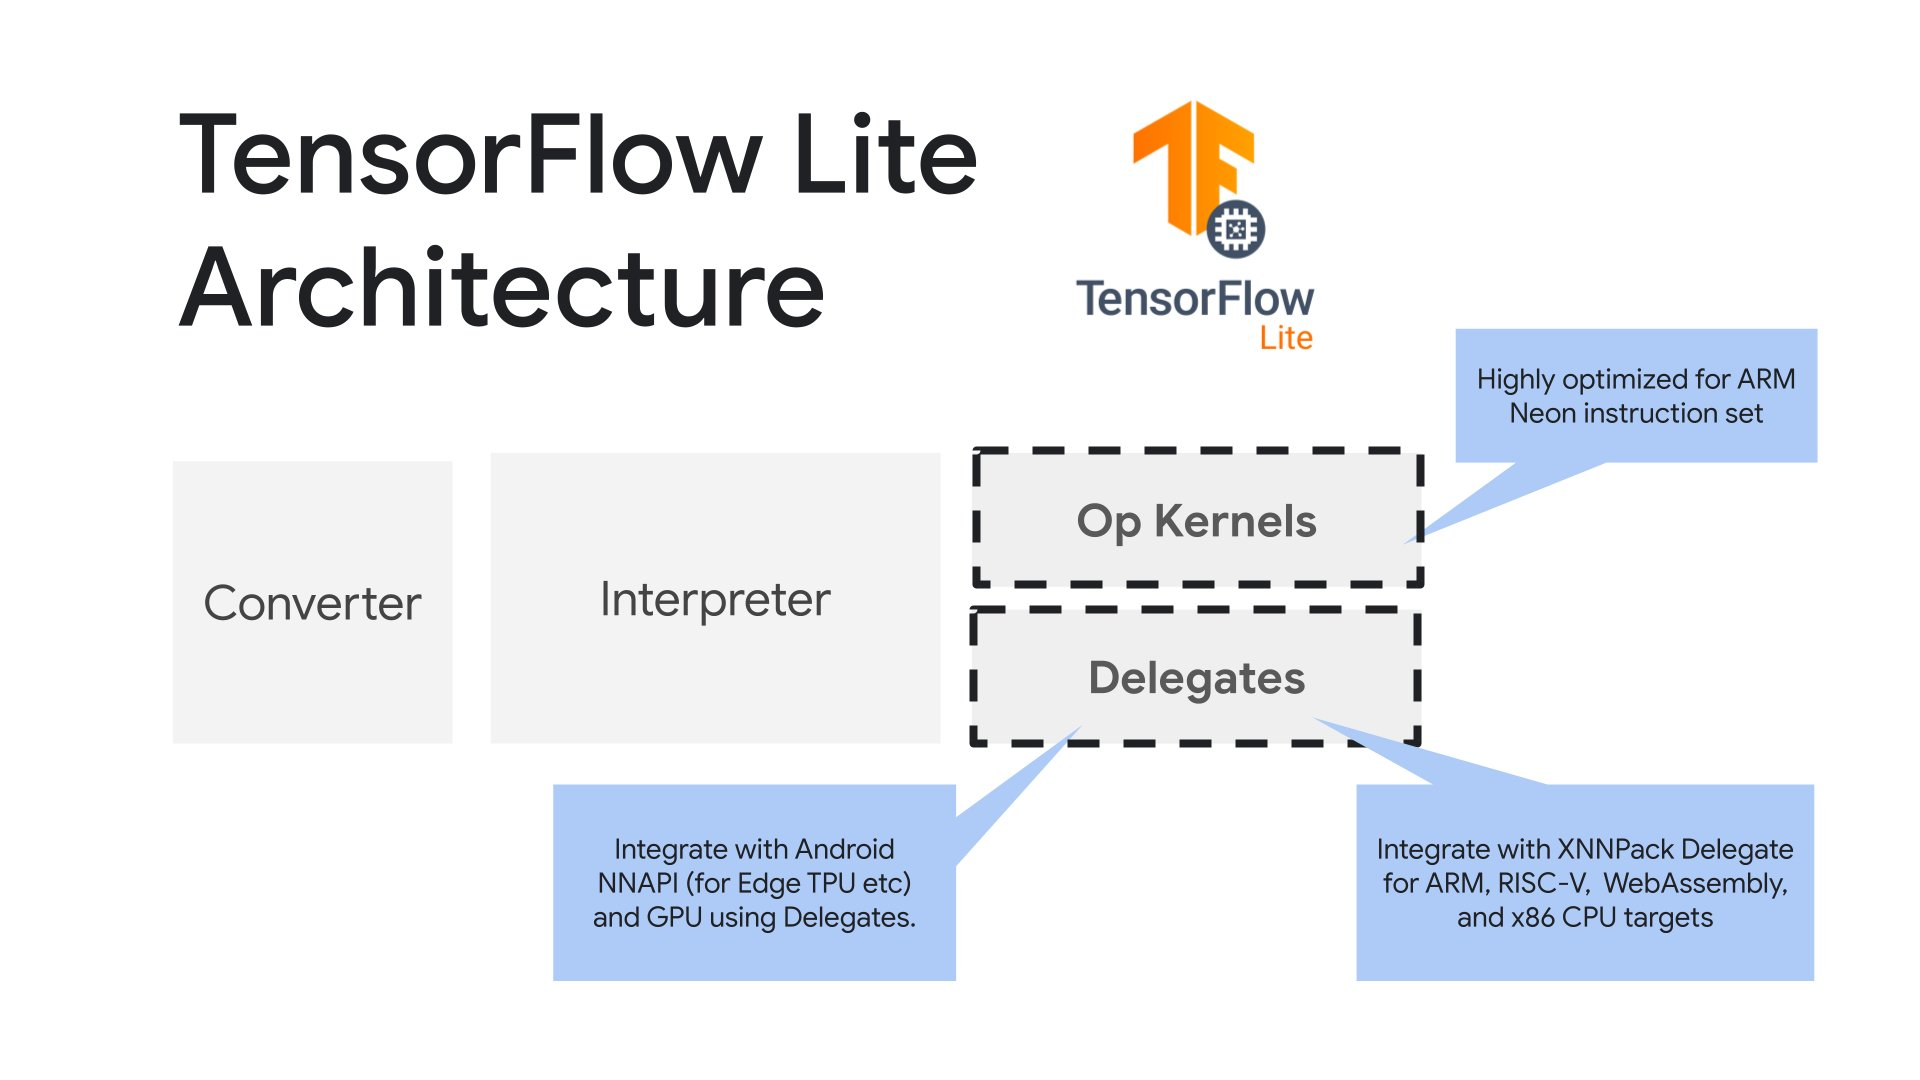

The high level developer workflow for using TensorFlow Lite is: first convert a TensorFlow model to the more compact TensorFlow Lite format using the TensorFlow Lite **converter**, and then use the TensorFlow Lite **interpreter**, which is highly optimized for mobile devices, to run the converted model. During the conversion process, you can also leverage several techniques, such as quantization, to further optimize the model and accelerate inference.

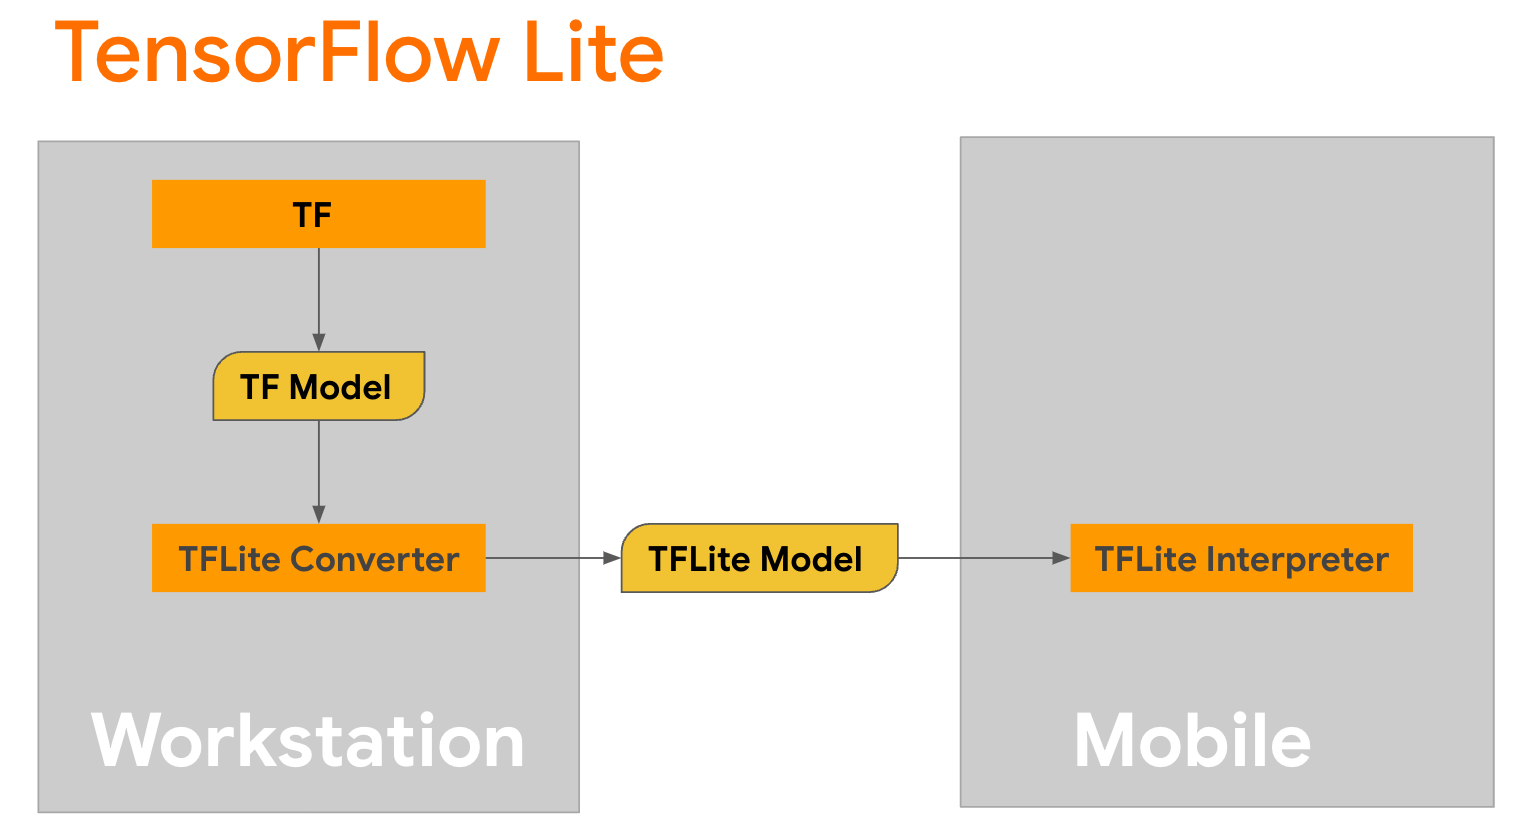

You will learn how to convert and optimize the finetuned GPT-2 model in the rest of this codelab (running inference on Android is covered in the next step of this workshop). To learn more the TFLite conversion process, you can visit this [page](https://www.tensorflow.org/lite/models/convert).

# Convert the `generate()` function from `GPT2CausalLM`

The `generate()` function from `GPT2CausalLM` is the actual function that does the magic. So you will convert it now. First, you wrap the `generate()` function into a TensorFlow concrete function.

In [ ]:
@tf.function
def generate(prompt, max_length):
    return gpt2_lm.generate(prompt, max_length)

concrete_func = generate.get_concrete_function(tf.TensorSpec([], tf.string), 100)

Now define a helper function to run inference with a given input and a TFLite model. Note that here TensorFlow Text ops are registered as custom ops so that the interpreter can run smoothly.

In [ ]:
def run_inference(input, generate_tflite):
  interp = interpreter.InterpreterWithCustomOps(
      model_content=generate_tflite,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)
  interp.get_signature_list()

  generator = interp.get_signature_runner('serving_default')
  output = generator(prompt=np.array([input]))
  print("\nGenerated with TFLite:\n", output["output_0"])

You can convert the model now. Note that the converter needs to pull in [select TensorFlow operators](https://www.tensorflow.org/lite/guide/ops_select) and enable custom ops due to model complexity.

In [ ]:
gpt2_lm.jit_compile = False
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func],
                                                            gpt2_lm)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.allow_custom_ops = True
converter.target_spec.experimental_select_user_tf_ops = ["UnsortedSegmentJoin", "UpperBound"]
converter._experimental_guarantee_all_funcs_one_use = True
generate_tflite = converter.convert()
run_inference("I'm enjoying a", generate_tflite)

Run the cell below to save the TFLite model.

In [ ]:
with open('unquantized_gpt2.tflite', 'wb') as f:
  f.write(generate_tflite)

Check out the size of the model.

In [ ]:
!ls -lh *.tflite

# Optimize the model with quantization

Right now the model is ~500MB and can already be run in an Android app if you want. But you can do better.

TensorFlow Lite has implemented an optimization technique called **quantization** to shrink down model size and accelerate model inference. Quantization is the process of mapping an input of continous values to a discrete set; in the machine learning context it is done by converting 32-bit floating numbers in the model weights to more efficient 8-bit integers, which leads to a 4x reduced model size and more efficient execution on modern hardwares.

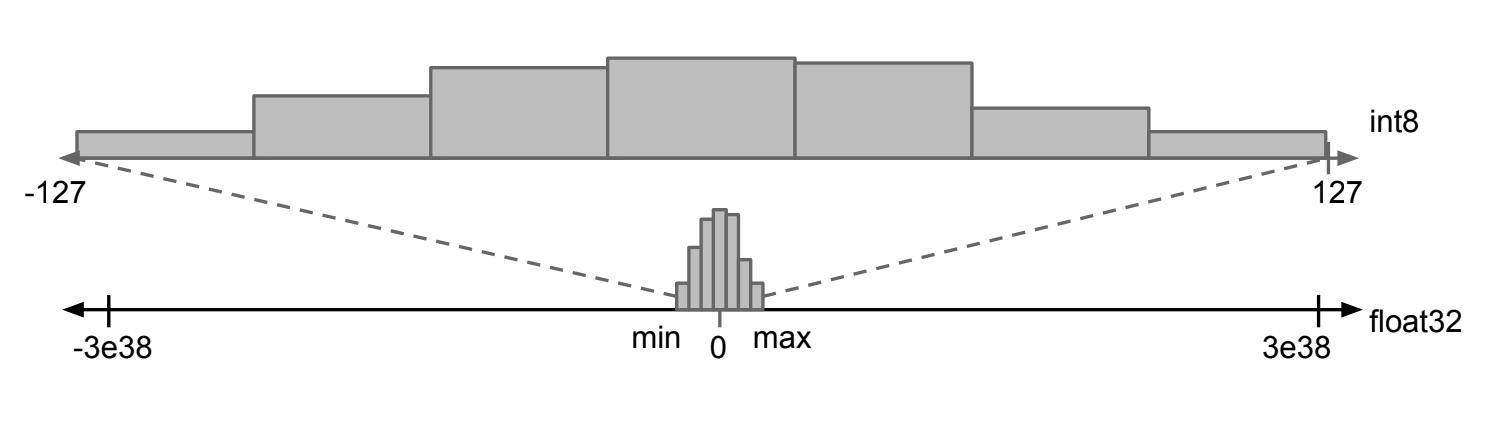

There are several flavors of quantizations implemented by TensorFlow Lite. You can visit the [TFLite Model optimization page](https://www.tensorflow.org/lite/performance/model_optimization) and [TensorFlow Model Optimization Toolkit page](https://www.tensorflow.org/model_optimization) to learn more.

In this workshop you will use the [post-training dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) by setting the converter optimization flag to 'tf.lite.Optimize.DEFAULT'. The rest of the converstion process is the same as before.

In [ ]:
gpt2_lm.jit_compile = False
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func],
                                                            gpt2_lm)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.experimental_select_user_tf_ops = ["UnsortedSegmentJoin", "UpperBound"]
converter._experimental_guarantee_all_funcs_one_use = True
quant_generate_tflite = converter.convert()
run_inference("I'm enjoying a", quant_generate_tflite)

Now save the quantized TFLite model.

In [ ]:
with open('quantized_gpt2.tflite', 'wb') as f:
  f.write(quant_generate_tflite)

You can compare the size of the quantized and non-quantized models, and see a 4x size reduction (~350MB), which is massive for mobile app distribution.

In [ ]:
!ls -lh *.tflite

Rename the quantized model to `autocomplete.tflite`, which is what will be used in the Android app.

In [ ]:
!mv quantized_gpt2.tflite autocomplete.tflite

Now you can download the `autocomplete.tflite` model file by going to the **Files** panel on the left of the Colab interface. You will use it in the next step of the codelab.